# Task 3
## Main objective
Cluster / classify the operational states of the shunting process: those could include whether a wagon is incoming, parked, shunted, positioned on the target track or outgoing, but it’s up to you to find the most useful categories for your classification model.
- Analyze the existing database
- Extract relevant features for your clustering model
- Develop a clustering model: you might gain a first overview with features depending on the geofence or the wagon moving state
- Evaluate the errors, uncertainty and robustness of the models and try to validate the models
- Is your algorithm also transferable on the long-term dataset? Describe the challenges, problems and critically discuss the quality of the results
- If data-related difficulties or impossibilities arise concerning the task, describe reasons and possible solutions

In [1]:
import pandas as pd
# import geopandas
import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import plotly.express as px
from sklearn.cluster import KMeans, OPTICS
from sklearn.mixture import GaussianMixture

#### Loading of the shunting data

In [2]:
shunting_data = pd.read_csv('data/raw/Maschen_211207_TUDA_data.csv')
shunting_data['wagon_ID'] = shunting_data['wagon_ID'].str.replace("'", '').astype(np.uint)
shunting_data['loading_state'] = shunting_data['loading_state'].replace('Beladen', True)
shunting_data['loading_state'] = shunting_data['loading_state'].replace('Leer', False)
shunting_data['loading_state'] = shunting_data['loading_state'].astype(np.bool_)
shunting_data['movement_state'] = shunting_data['movement_state'].str.replace('parking', '0')
shunting_data['movement_state'] = shunting_data['movement_state'].str.replace('standing', '1')
shunting_data['movement_state'] = shunting_data['movement_state'].str.replace('moving', '2')
shunting_data['movement_state'] = shunting_data['movement_state'].fillna('3')
shunting_data['movement_state'] = shunting_data['movement_state'].astype(np.uint8)
shunting_data['loading_state_update'] = pd.to_timedelta(shunting_data['loading_state_update'])
shunting_data['timestamp_measure_position'] = pd.to_timedelta(shunting_data['timestamp_measure_position'])
shunting_data['timestamp_transfer'] = pd.to_timedelta(shunting_data['timestamp_transfer'])
shunting_data['timestamp_measure_movement_state'] = pd.to_timedelta(shunting_data['timestamp_measure_movement_state'])
shunting_data['timestamp_index'] = pd.to_timedelta(shunting_data['timestamp_index'])

In [3]:
shunting_data.dtypes

wagon_ID                                     uint64
loading_state                                  bool
loading_state_update                timedelta64[ns]
altitude                                    float64
latitude                                    float64
longitude                                   float64
signal_quality_satellite                    float64
signal_quality_hdop                         float64
determination_position                        int64
GNSS_velocity                               float64
timestamp_measure_position          timedelta64[ns]
timestamp_transfer                  timedelta64[ns]
movement_state                                uint8
timestamp_measure_movement_state    timedelta64[ns]
timestamp_index                     timedelta64[ns]
provider                                      int64
dtype: object

In [4]:
# fig = px.scatter_mapbox(shunting_data[::50], lat='latitude', lon='longitude', height=800)
# # fig.update_layout(mapbox_style='open-street-map')
# fig.update_layout(
#     mapbox_style="white-bg",
#     mapbox_layers=[
#         {
#             "below": 'traces',
#             "sourcetype": "raster",
#             "sourceattribution": "OpenRailwayMap",
#             "source": [
#                 "https://a.tiles.openrailwaymap.org/standard/{z}/{x}/{y}.png"
#             ]
#         }
#       ])

# fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
# fig.show()

### Filter only data from within Maschen

In [5]:
# clustering_data = shunting_data[10.03 < shunting_data['longitude']].dropna()
# clustering_data = clustering_data[clustering_data['longitude'] < 10.09]
# clustering_data = clustering_data[53.39 < clustering_data['latitude']]
# clustering_data = clustering_data[clustering_data['latitude'] < 53.42]
# clustering_data['dir'] = 0
clustering_data = shunting_data[9.9922 < shunting_data['longitude']].dropna()
clustering_data = clustering_data[clustering_data['longitude'] < 10.20]
clustering_data = clustering_data[53.35493 < clustering_data['latitude']]
clustering_data = clustering_data[clustering_data['latitude'] < 53.45592]
clustering_data['dir'] = 0

In [6]:
# cluster = KMeans(n_clusters=8).fit_predict(clustering_data[['longitude', 'latitude', 'GNSS_velocity']])
cluster = GaussianMixture(n_components=6, verbose=1).fit_predict(clustering_data[['longitude', 'latitude', 'dir']])

Initialization 0
  Iteration 10
Initialization converged: True


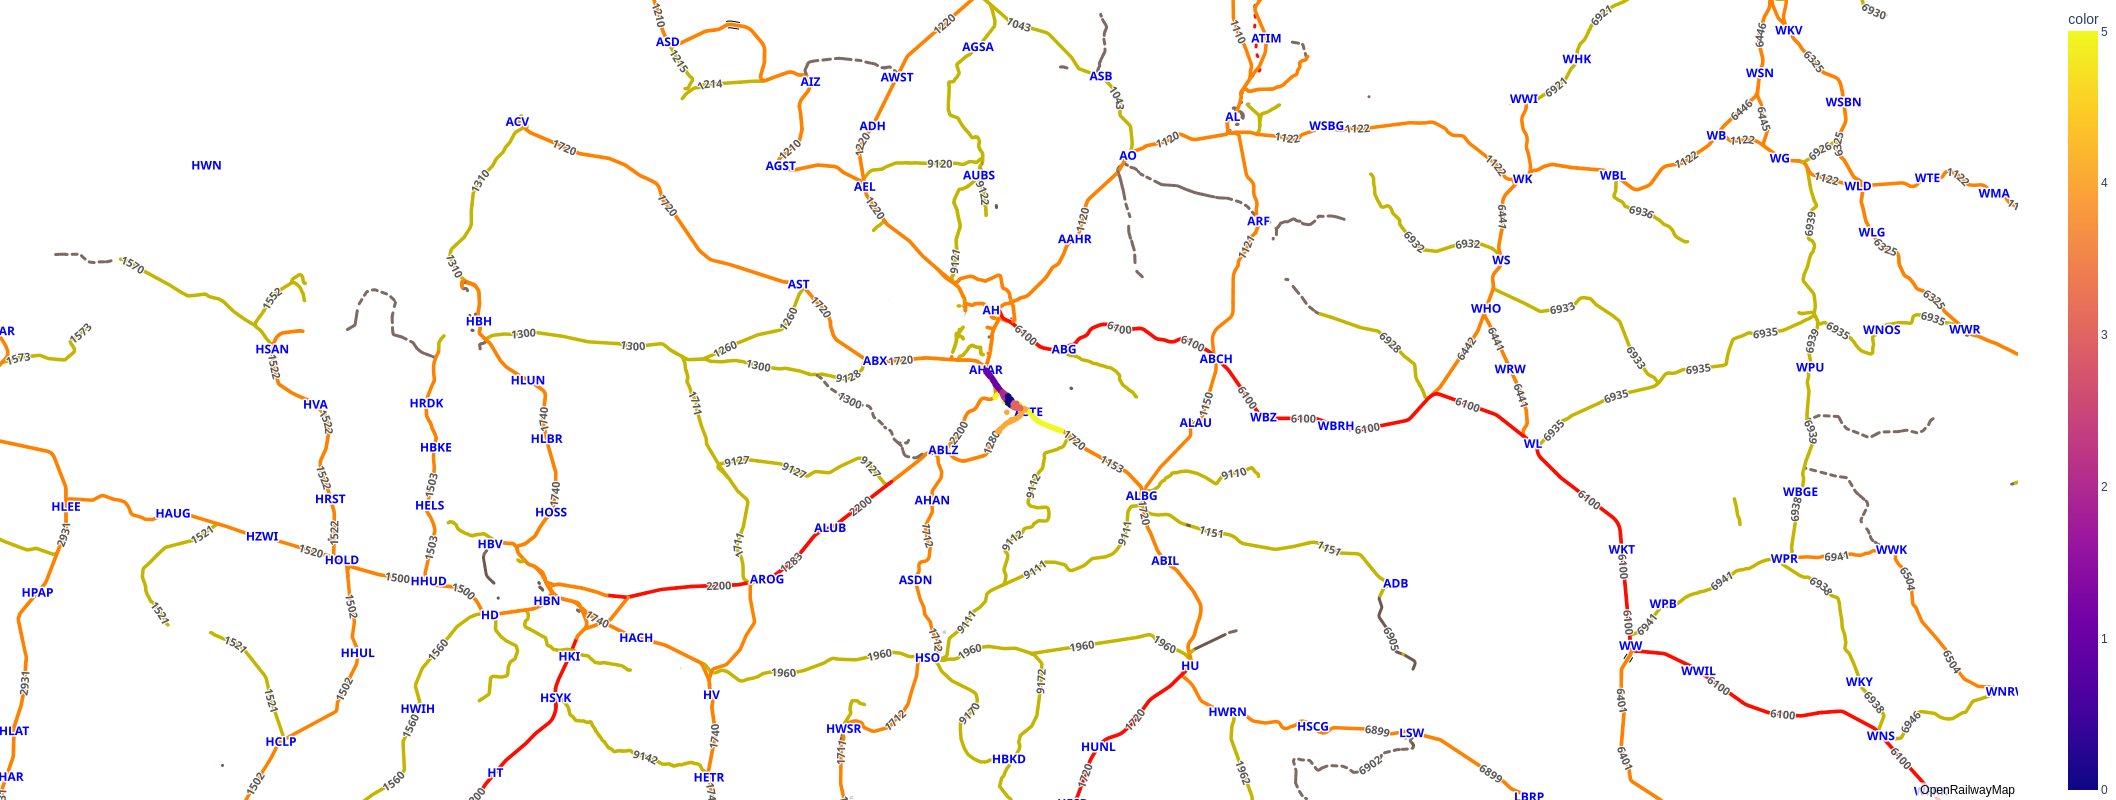

In [7]:
fig = px.scatter_mapbox(clustering_data[::50], lat='latitude', lon='longitude', height=800, color=cluster[::50])
# fig.update_layout(mapbox_style='open-street-map')
fig.update_layout(
    mapbox_style="white-bg",
    mapbox_layers=[
        {
            "below": 'traces',
            "sourcetype": "raster",
            "sourceattribution": "OpenRailwayMap",
            "source": [
                "https://a.tiles.openrailwaymap.org/standard/{z}/{x}/{y}.png"
            ]
        }
      ])

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [8]:
s_clustering_data = clustering_data.sort_values(['wagon_ID', 'timestamp_measure_position'])
s_clustering_data

wagon_ID  loading_state loading_state_update  altitude  \
1130057   697603200002475          False    243 days 12:09:34       7.0   
1130045   697603200002475          False    243 days 12:09:34      21.0   
1130047   697603200002475          False    243 days 13:09:33      15.0   
1130048   697603200002475          False    243 days 14:09:38       9.0   
1130061   697603200002475          False    243 days 14:09:38      16.0   
...                   ...            ...                  ...       ...   
1968600  3073003522066640           True    272 days 12:10:13       6.9   
1968609  3073003522066640           True    272 days 12:10:13       6.9   
1968601  3073003522066640           True    272 days 12:10:13       3.2   
1968608  3073003522066640           True    272 days 12:10:13       3.2   
1968602  3073003522066640           True    272 days 13:09:52      19.0   

          latitude  longitude  signal_quality_satellite  signal_quality_hdop  \
1130057  53.405620  10.058670                       5.0                  4.0   
1130045  53.397243  10.073604                       5.0                  4.0   
1130047  53.397312  10.073720                      14.0                  1.0   
1130048  53.401432  10.064401                       7.0                  2.0   
1130061  53.401848  10.063766                       7.0                  2.0   
...            ...        ...                       ...                  ...   
1968600  53.415220  10.039763                      12.0                  2.2   
1968609  53.415220  10.039763                      12.0                  2.2   
1968601  53.404115  10.051851                      10.0                  2.2   
1968608  53.404115  10.051851                      10.0                  2.2   
1968602  53.393853  10.077839                      12.0                  2.3   

         determination_position  GNSS_velocity timestamp_measure_position  \
1130057                       1          22.68          243 days 13:10:44   
1130045                       1           1.08          243 days 13:15:18   
1130047                       1           0.00          243 days 13:45:16   
1130048                       1           2.88          243 days 14:33:34   
1130061                       1           4.68          243 days 14:34:34   
...                         ...            ...                        ...   
1968600                       1           0.00   272 days 13:04:31.346000   
1968609                       1           0.00          272 days 13:08:28   
1968601                       1           0.00   272 days 13:10:18.378000   
1968608                       1           0.00          272 days 13:19:26   
1968602                       1           0.00   272 days 13:25:11.379000   

              timestamp_transfer  movement_state  \
1130057 243 days 13:10:52.849000               2   
1130045 243 days 13:15:28.388000               1   
1130047 243 days 13:45:23.991000               0   
1130048 243 days 14:33:43.472000               2   
1130061 243 days 14:34:45.252000               1   
...                          ...             ...   
1968600 272 days 13:04:45.956000               1   
1968609 272 days 13:09:15.800000               2   
1968601 272 days 13:10:36.284000               1   
1968608 272 days 13:20:05.190000               2   
1968602 272 days 13:25:39.597000               1   

        timestamp_measure_movement_state   timestamp_index  provider  dir  
1130057                243 days 13:09:54 243 days 13:10:55        32    0  
1130045                243 days 13:14:42 243 days 13:15:31        32    0  
1130047                243 days 13:45:08 243 days 13:45:27        32    0  
1130048                243 days 14:32:55 243 days 14:33:46        32    0  
1130061                243 days 14:34:01 243 days 14:34:48        32    0  
...                                  ...               ...       ...  ...  
1968600         272 days 13:04:31.346000 272 days 13:04:54        35    0

In [37]:
# s_clustering_data
wagon_ID = 0
direction = 0 # 1 up; -1 down
last_update = pd.Timedelta(0)
last_lat = 0
last_long = 0

pbar = tqdm(total=s_clustering_data.shape[0])

for index, row in s_clustering_data.iterrows():
    if (row['wagon_ID'] != wagon_ID):
        wagon_ID = row['wagon_ID']
        last_update = row['timestamp_measure_movement_state']
        direction = 1 if row['latitude']<53.40539 else -1
        s_clustering_data.at[index, 'dir'] = direction
    else:
        if ((last_lat-row['latitude'])**2 + (last_long-row['longitude'])**2) < 0.002**2:    
            s_clustering_data.at[index, 'dir'] = direction
        else:
            direction = 1 if last_lat-row['latitude'] <0 else -1
            s_clustering_data.at[index, 'dir'] = direction
        last_update = row['timestamp_measure_movement_state']
    last_lat = row['latitude']
    last_long = row['longitude']
    pbar.update(1)
pbar.close()

  0%|          | 0/575881 [00:00<?, ?it/s]

Initialization 0
  Iteration 10
Initialization converged: True


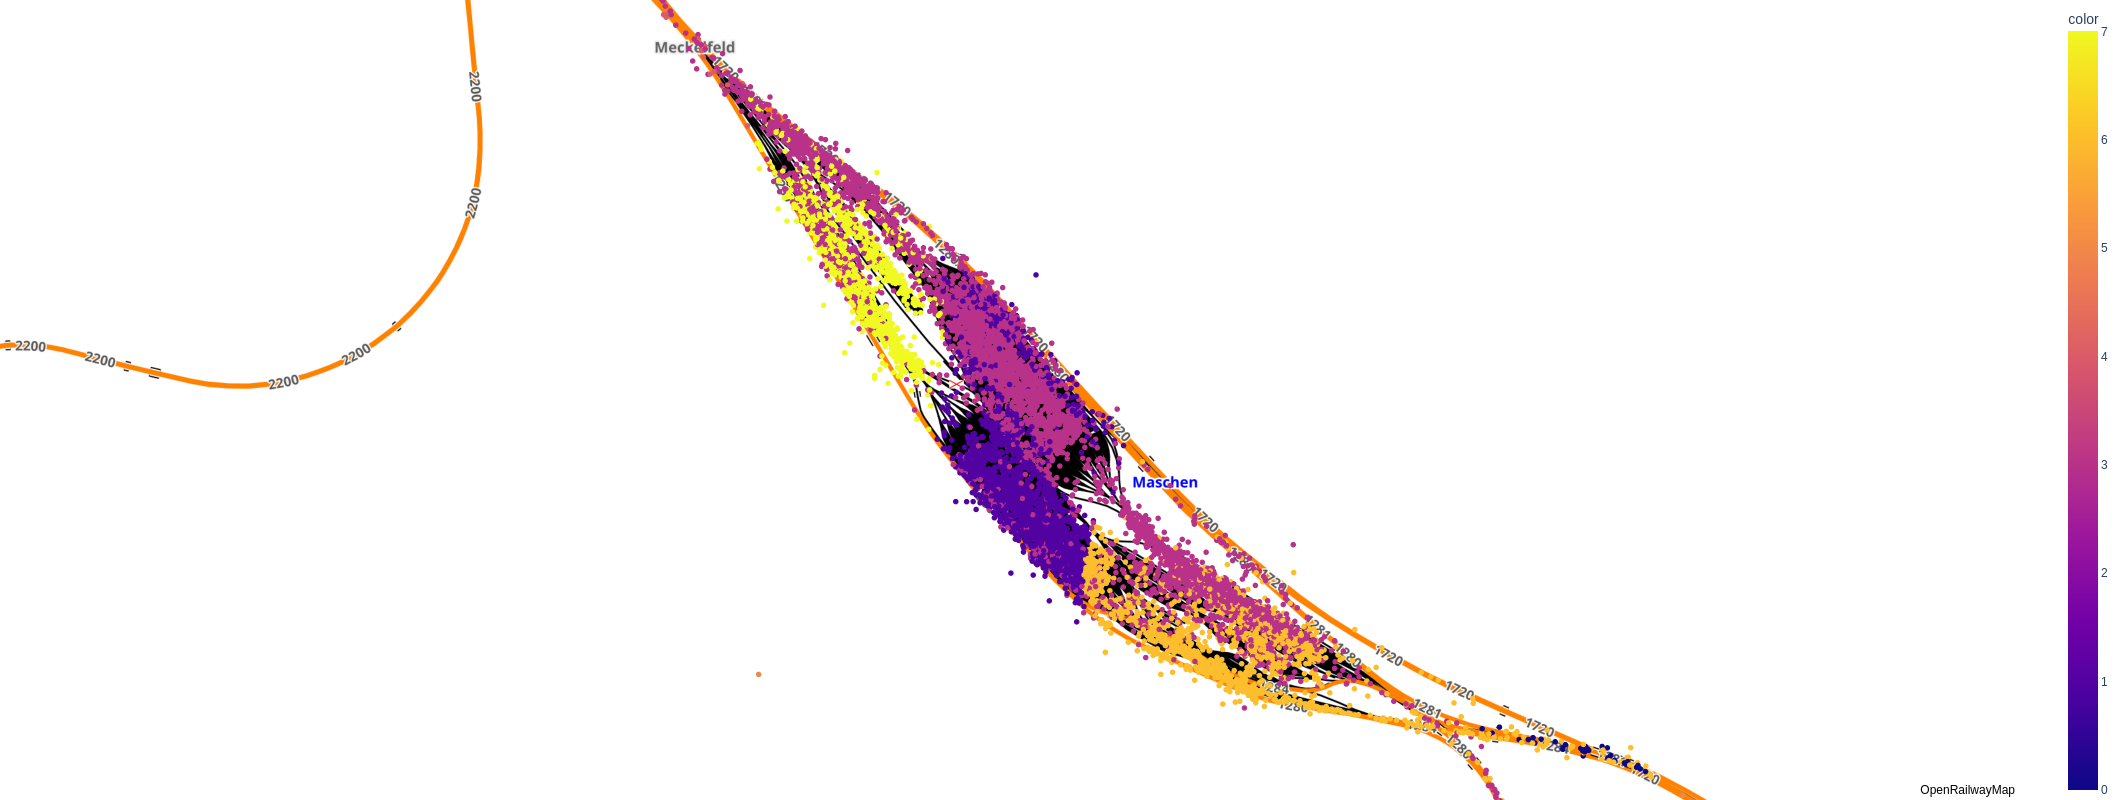

                wagon_ID  loading_state loading_state_update  altitude  \
1130057  697603200002475          False    243 days 12:09:34       7.0   
1130045  697603200002475          False    243 days 12:09:34      21.0   
1130047  697603200002475          False    243 days 13:09:33      15.0   
1130048  697603200002475          False    243 days 14:09:38       9.0   
1130061  697603200002475          False    243 days 14:09:38      16.0   

          latitude  longitude  signal_quality_satellite  signal_quality_hdop  \
1130057  53.405620  10.058670                       5.0                  4.0   
1130045  53.397243  10.073604                       5.0                  4.0   
1130047  53.397312  10.073720                      14.0                  1.0   
1130048  53.401432  10.064401                       7.0                  2.0   
1130061  53.401848  10.063766                       7.0                  2.0   

         determination_position  GNSS_velocity timestamp_measure_position 

In [43]:
cluster = GaussianMixture(n_components=8, verbose=1).fit_predict(s_clustering_data[['longitude', 'latitude', 'dir']])
# cluster = OPTICS().fit_predict(s_clustering_data[['longitude', 'latitude', 'dir']])
fig = px.scatter_mapbox(s_clustering_data[::50], lat='latitude', lon='longitude', height=800, color=cluster[::50], zoom=13.3)
# fig.update_layout(mapbox_style='open-street-map')
fig.update_layout(
    mapbox_style="white-bg",
    mapbox_layers=[
        {
            "below": 'traces',
            "sourcetype": "raster",
            "sourceattribution": "OpenRailwayMap",
            "source": [
                "https://a.tiles.openrailwaymap.org/standard/{z}/{x}/{y}.png"
            ]
        }
      ])

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()
print(s_clustering_data.head())

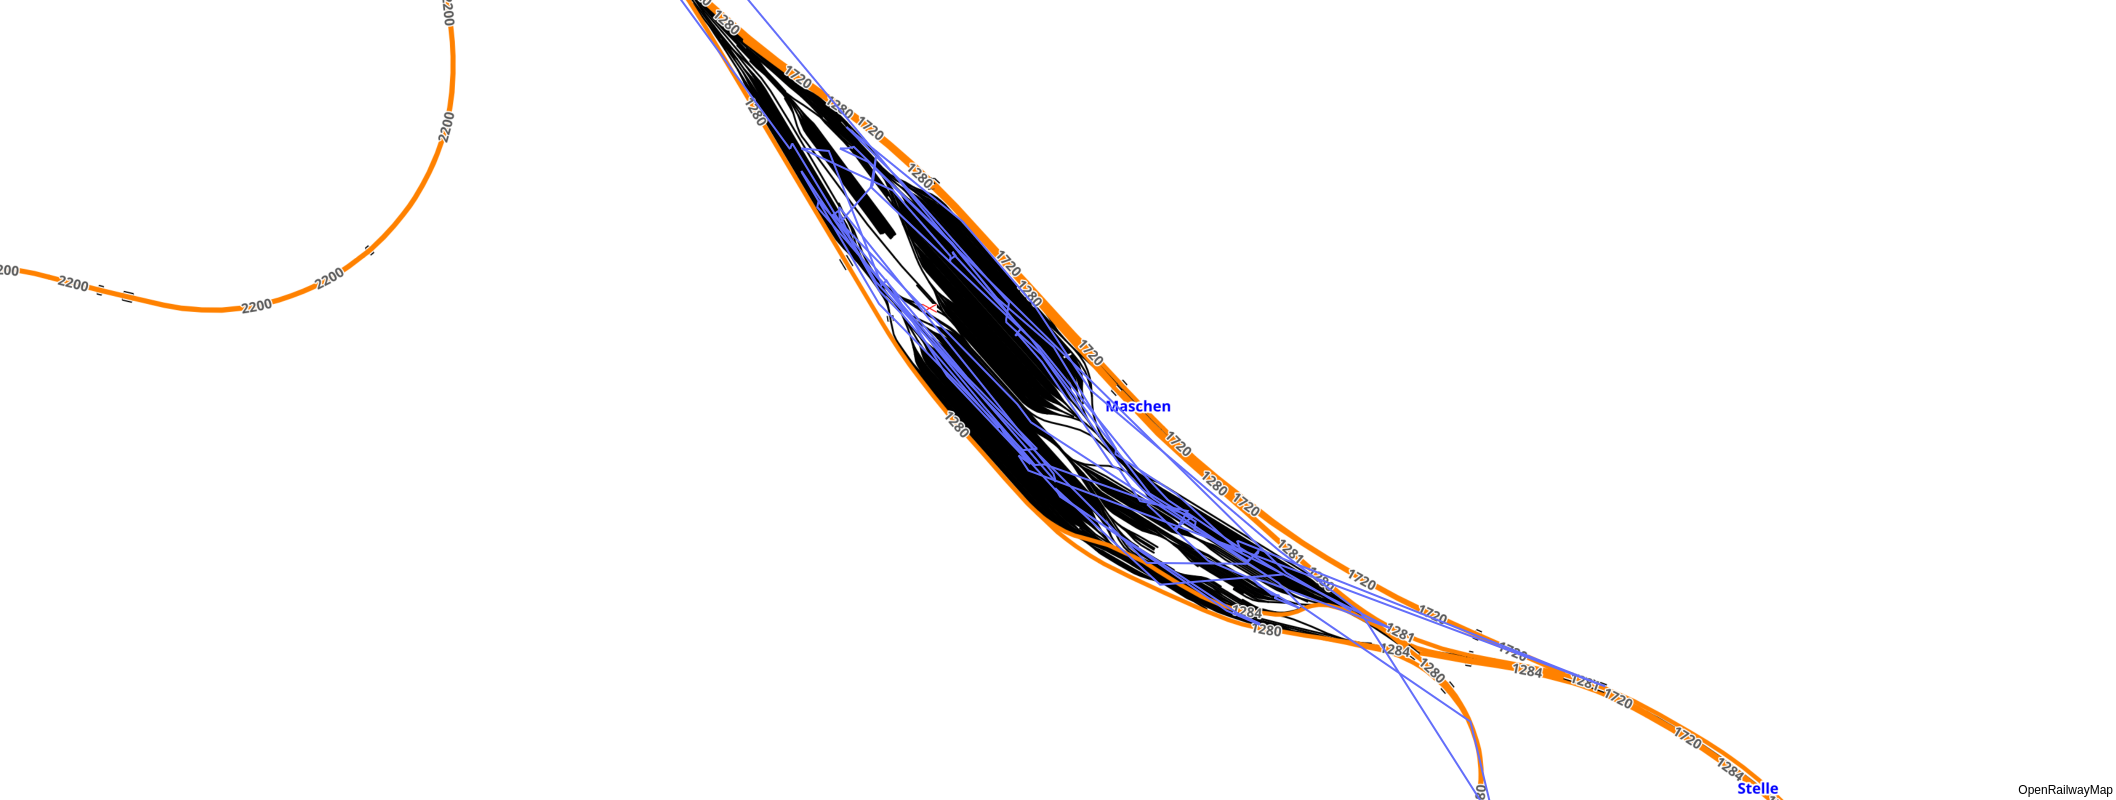

In [44]:
test = s_clustering_data.sample(n=1)
single_wagon_data = s_clustering_data[s_clustering_data['wagon_ID']==test.wagon_ID.values[0]].sort_values('timestamp_measure_position')
fig = px.line_mapbox(single_wagon_data, lat='latitude', lon='longitude', height=800, zoom=13.3, hover_data=['timestamp_measure_position', 'dir'])
# fig.update_layout(mapbox_style='open-street-map')
fig.update_layout(
    mapbox_style="white-bg",
    mapbox_layers=[
        {
            "below": 'traces',
            "sourcetype": "raster",
            "sourceattribution": "OpenRailwayMap",
            "source": [
                "https://a.tiles.openrailwaymap.org/standard/{z}/{x}/{y}.png"
            ]
        }
      ])

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()